In [1]:
import pandas as pd

In [369]:
ball = pd.read_csv("/Users/annadaugaard/Desktop/VFF/explore/data/labelled_match_ball.csv", index_col=0)
event_data = pd.read_csv("/Users/annadaugaard/Desktop/VFF/raw_data/sample_match_1/Sample_Game_1_RawEventsData.csv")
event_data_passes = event_data[event_data["Type"] == "PASS"]



In [370]:
event_data_passes

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
1,Away,PASS,NaN,1,1,0.04,3,0.12,Player19,Player21,0.45,0.39,0.55,0.43
2,Away,PASS,NaN,1,3,0.12,17,0.68,Player21,Player15,0.55,0.43,0.58,0.21
3,Away,PASS,NaN,1,45,1.80,61,2.44,Player15,Player19,0.55,0.19,0.45,0.31
4,Away,PASS,NaN,1,77,3.08,96,3.84,Player19,Player21,0.45,0.32,0.49,0.47
5,Away,PASS,NaN,1,191,7.64,217,8.68,Player21,Player22,0.40,0.73,0.32,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1731,Away,PASS,NaN,2,142715,5708.60,142755,5710.20,Player20,Player27,0.41,0.33,0.60,0.04
1736,Away,PASS,NaN,2,143130,5725.20,143137,5725.48,Player16,Player18,0.50,0.37,0.61,0.53
1739,Home,PASS,NaN,2,143262,5730.48,143297,5731.88,Player14,Player12,0.75,0.22,0.71,0.28
1740,Home,PASS,NaN,2,143361,5734.44,143483,5739.32,Player12,Player13,0.60,0.33,0.19,0.95


In [371]:
event_data_passes["From"] = (event_data_passes["From"].astype(str).str.replace("Player", "", regex=True)).astype(int)
event_data_passes["To"] = (event_data_passes["To"].astype(str).str.replace("Player", "", regex=True)).astype(int)
event_data_passes["Start X"] = (event_data_passes["Start X"]).astype(float) * 106
event_data_passes["End X"] = (event_data_passes["End X"]).astype(float) * 106
event_data_passes["Start Y"] = (event_data_passes["Start Y"]).astype(float) * 68
event_data_passes["End Y"] = (event_data_passes["End Y"]).astype(float) * 68

/var/folders/hg/l2wdlfb97db6m9qjl00xzxg40000gn/T/ipykernel_44538/1994316054.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data_passes["From"] = (event_data_passes["From"].astype(str).str.replace("Player", "", regex=True)).astype(int)
/var/folders/hg/l2wdlfb97db6m9qjl00xzxg40000gn/T/ipykernel_44538/1994316054.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data_passes["To"] = (event_data_passes["To"].astype(str).str.replace("Player", "", regex=True)).astype(int)
/var/folders/hg/l2wdlfb9

In [372]:

ball = ball.dropna()
# Calculate differences to compute speed
ball['dx'] = ball['ball_x'].diff()
ball['dy'] = ball['ball_y'].diff()
ball['dt'] = ball['time'].diff()

# Calculate speed (Euclidean distance per time difference)
ball['speed'] = np.sqrt(ball['dx']**2 + ball['dy']**2) / ball['dt']

ball['acceleration'] = ball["speed"].diff() / ball['time'].diff()
ball = ball[ball['speed'] <= 36]
# Drop intermediate calculation columns from the cleaned tracking data
ball.drop(columns=['dx', 'dy', 'dt'], inplace=True)

In [393]:

def filter_pass_events_by_timestamp_coverage(pass_df, time_df, step=0.04, missing_threshold=0.30):
    """
    Filters pass events based on timestamp coverage.
    
    For each pass event in pass_df (with columns "Start Time [s]" and "End Time [s]"),
    a sequence of expected timestamps is generated from start to end with intervals of 'step' seconds.
    The function then checks how many of these expected timestamps are present in time_df["time"].
    If more than missing_threshold (default 30%) of the expected timestamps are missing, the event is discarded.
    
    Parameters:
      pass_df (pd.DataFrame): DataFrame containing pass events with "Start Time [s]" and "End Time [s]".
      time_df (pd.DataFrame): DataFrame containing available timestamps in a column named "time".
      step (float): The time step for generating expected timestamps (default 0.04).
      missing_threshold (float): Maximum allowable fraction of missing timestamps (default 0.30).
    
    Returns:
      pd.DataFrame: A filtered version of pass_df.
    """
    # Create a set of available timestamps from time_df, rounding to 2 decimals
    available_times = set(np.round(time_df["time"].values, 2))
    
    filtered_rows = []
    for _, row in pass_df.iterrows():
        start = row["Start Time [s]"]
        end = row["End Time [s]"]
        # Generate expected timestamps from start to end (inclusive) using step of 0.04.
        # Adding half-step to ensure inclusion of the endpoint in floating-point arithmetic.
        expected_times = np.arange(start, end + step/2, step)
        # Round expected times for safe comparison.
        expected_times = np.round(expected_times, 2)
        expected_count = len(expected_times)
        # Count how many expected timestamps are found in available_times.
        found_count = sum(1 for t in expected_times if t in available_times)
        missing_fraction = 1 - (found_count / expected_count) if expected_count > 0 else 0
        
        # If the fraction of missing timestamps is at most the threshold, keep the event.
        if missing_fraction <= missing_threshold:
            filtered_rows.append(row)
    
    return pd.DataFrame(filtered_rows)


# Apply the filter function:
filtered_pass_df = filter_pass_events_by_timestamp_coverage(event_data_passes, ball, step=0.04, missing_threshold=0.0)

print("Filtered Pass Events:")
print(filtered_pass_df)

Filtered Pass Events:
      Team  Type Subtype  Period  Start Frame  Start Time [s]  End Frame  \
3     Away  PASS     NaN       1           45            1.80         61   
4     Away  PASS     NaN       1           77            3.08         96   
5     Away  PASS     NaN       1          191            7.64        217   
6     Away  PASS     NaN       1          279           11.16        303   
16    Home  PASS     NaN       1          536           21.44        556   
...    ...   ...     ...     ...          ...             ...        ...   
1730  Away  PASS     NaN       2       142665         5706.60     142695   
1731  Away  PASS     NaN       2       142715         5708.60     142755   
1739  Home  PASS     NaN       2       143262         5730.48     143297   
1740  Home  PASS     NaN       2       143361         5734.44     143483   
1741  Home  PASS     NaN       2       143578         5743.12     143593   

      End Time [s]  From  To  Start X  Start Y  End X  End Y  
3 

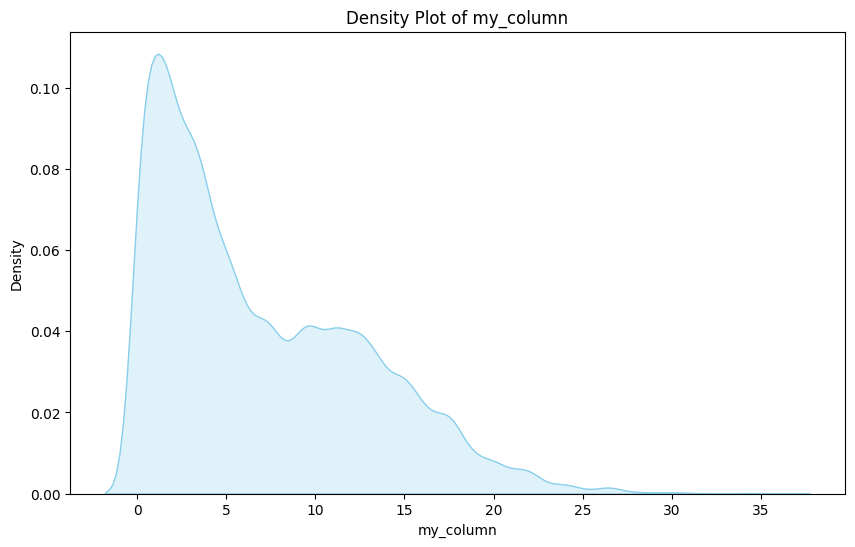

In [374]:
# Define a threshold for outliers (e.g., z-score > 3 or < -3)
import matplotlib.pyplot as plt

import seaborn as sns
# Create a density plot on the column 'my_column'
plt.figure(figsize=(10, 6))
sns.kdeplot(data=ball, x='speed', fill=True, color='skyblue')
plt.title('Density Plot of my_column')
plt.xlabel('my_column')
plt.ylabel('Density')
plt.show()

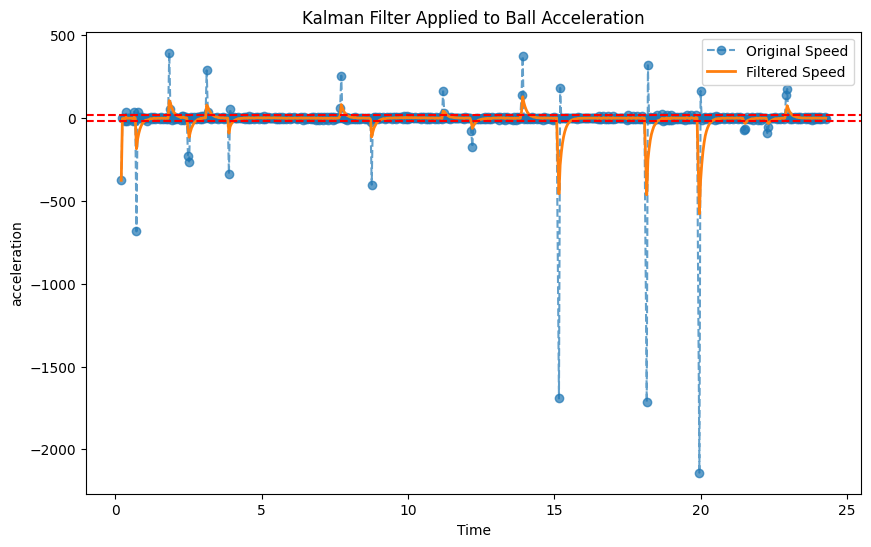

In [375]:
def kalman_filter_speed(speed_data, process_variance=1e-3, measurement_variance=0.1):
    """
    Apply a simple one-dimensional Kalman filter to a 1D array of speed measurements.
    
    Parameters:
      speed_data (array-like): The measured speeds.
      process_variance (float): Variance of the process noise.
      measurement_variance (float): Variance of the measurement noise.
      
    Returns:
      np.array: The filtered speed estimates.
    """
    n = len(speed_data)
    # Allocate arrays for estimates and error covariance.
    xhat = np.zeros(n)  # Filtered estimate.
    P = np.zeros(n)     # Estimate error covariance.
    
    # Initialize with the first measurement.
    xhat[0] = speed_data[0]
    P[0] = 1.0  # initial uncertainty
    
    for k in range(1, n):
        # Prediction step: assume the state (speed) doesn't change
        xhatminus = xhat[k-1]
        Pminus = P[k-1] + process_variance
        
        # Update step: incorporate the measurement at time k
        K = Pminus / (Pminus + measurement_variance)
        xhat[k] = xhatminus + K * (speed_data[k] - xhatminus)
        P[k] = (1 - K) * Pminus
        
    return xhat

# Example usage:
# Let's assume you have a DataFrame with a column 'speed'
# Here we create some synthetic data for demonstration.

# Apply the Kalman filter to the 'speed' column.
ball['filtered_acceleration'] = kalman_filter_speed(ball['acceleration'].values, process_variance=1e-3, measurement_variance=0.01)


# Plot the results.
plt.figure(figsize=(10,6))
plt.plot(ball['time'][0:600], ball['acceleration'][0:600], label='Original Speed', marker='o', linestyle='--', alpha=0.7)
plt.plot(ball['time'][0:600], ball['filtered_acceleration'][0:600], label='Filtered Speed', linewidth=2)
plt.xlabel("Time")
plt.ylabel("acceleration")
plt.title("Kalman Filter Applied to Ball Acceleration")
plt.axhline(y=20, color='red', linestyle='--', linewidth=1.5)
plt.axhline(y=-20, color='red', linestyle='--', linewidth=1.5)

plt.legend()
plt.show()


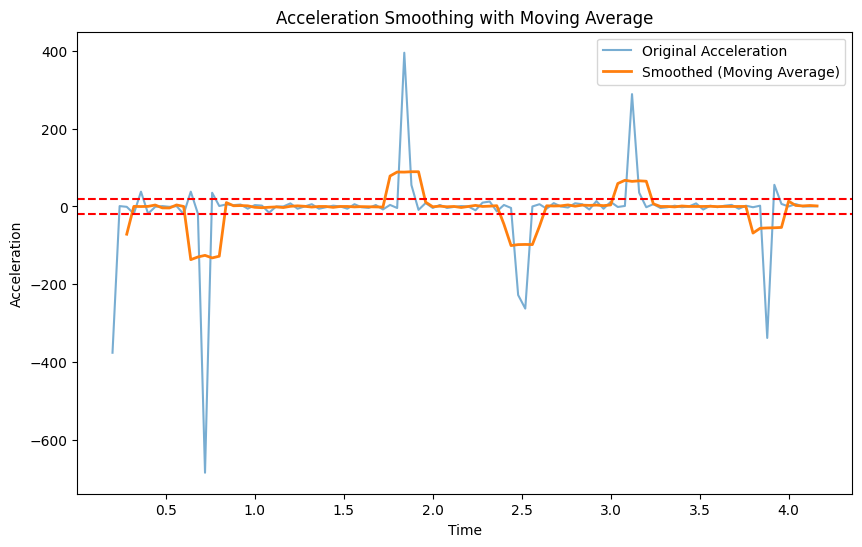

In [397]:
window_size = 5

# Create a new column for the moving average smoothed acceleration
ball['smoothed_acceleration'] = ball['acceleration'].rolling(window=window_size, center=True).mean()

# Plot for comparison
plt.figure(figsize=(10,6))
plt.plot(ball['time'][0:100], ball['acceleration'][0:100], label='Original Acceleration', alpha=0.6)
plt.plot(ball['time'][0:100], ball['smoothed_acceleration'][0:100], label='Smoothed (Moving Average)', linewidth=2)
plt.axhline(y=20, color='red', linestyle='--', linewidth=1.5)
plt.axhline(y=-20, color='red', linestyle='--', linewidth=1.5)
plt.xlabel("Time")
plt.ylabel("Acceleration")
plt.legend()
plt.title("Acceleration Smoothing with Moving Average")
plt.show()


In [398]:
ball['smoothed_acceleration_observed'] = [1 if abs(x) >= 20 else 0 for x in ball['smoothed_acceleration']]
sum(1 for x in ball['filtered_acceleration'] if abs(x) >= 20) / sum(1 for x in ball['filtered_acceleration']) 

0.09741993387941514

In [378]:
players = pd.read_csv("/Users/annadaugaard/Desktop/VFF/explore/data/labelled_match_players.csv", index_col=0)

In [379]:
players_and_ball = players.merge(ball, on="time", how="left")

In [380]:
players_and_ball = players_and_ball.dropna()
# Compute the Euclidean distance from the player (x, y) to the ball (ball_x, ball_y)
players_and_ball["distance_to_ball"] = np.sqrt((players_and_ball["x"] - players_and_ball["ball_x"])**2 +
                                          (players_and_ball["y"] - players_and_ball["ball_y"])**2)

# For each time point, rank the players by distance (1 = closest)
players_and_ball["distance_rank"] = players_and_ball.groupby("time")["distance_to_ball"].rank(method="min")
threshold = 3.0

# For each time point, count how many players are within the threshold distance to the ball.
# We use groupby with transform so that every row for the same time gets the same count.
players_and_ball["uncertainty_index"] = players_and_ball.groupby("time")["distance_to_ball"].transform(
    lambda x: (x <= threshold).sum()
)

rank_1= players_and_ball[players_and_ball["distance_rank"] == 1]
rank_1_index= rank_1[rank_1["smoothed_acceleration_observed"] == 1]

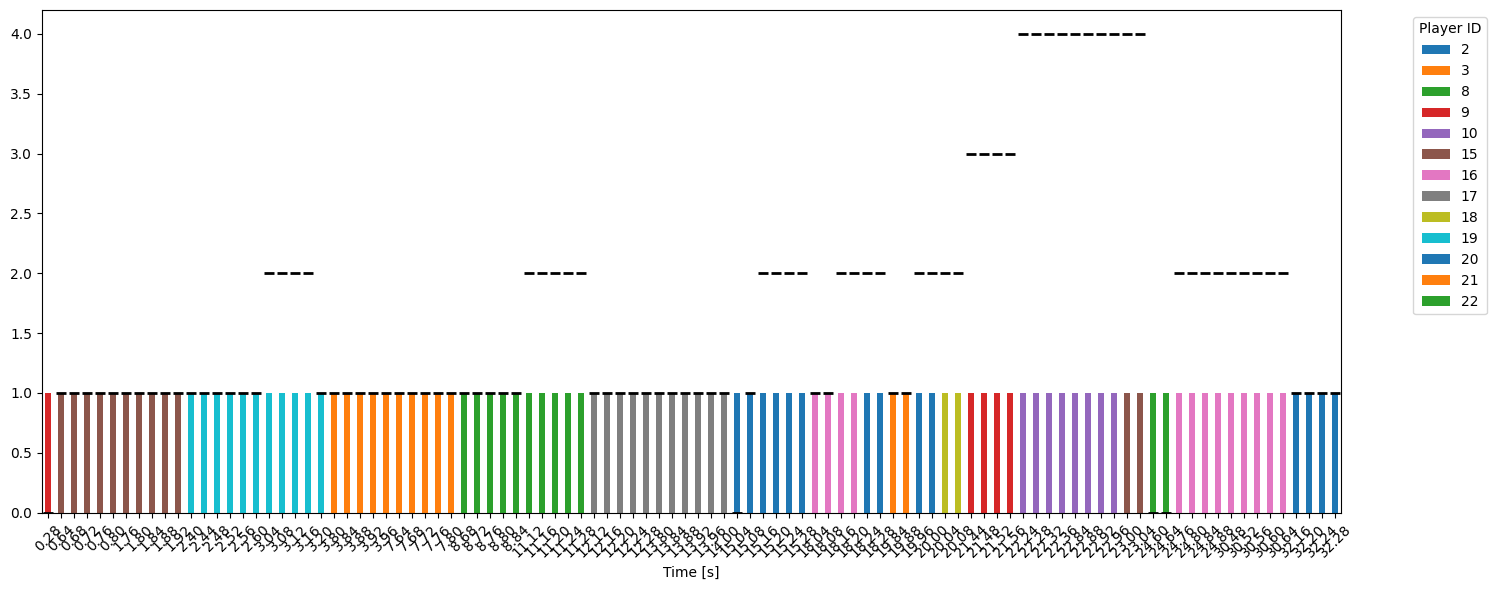

In [381]:
import numpy as np
import matplotlib.pyplot as plt

# Example: group by time and id, then count occurrences
grouped = rank_1_index[0:100].groupby(["time", "id"]).size().unstack(fill_value=0)

# Create a stacked bar plot of counts.
ax = grouped.plot(kind="bar", stacked=True, figsize=(15, 6))
plt.legend(title="Player ID", bbox_to_anchor=(1.05, 1), loc="upper left")

# Compute an uncertainty index per time.
# For example, take the maximum uncertainty_index value at each time.
uncertainty_by_time = rank_1_index[0:100].groupby("time")["uncertainty_index"].max()

# Get the unique times (the index of 'grouped'); these serve as our x-axis ticks.
unique_times = grouped.index
x_positions = np.arange(len(unique_times))

# Ensure the uncertainty series is aligned to the same unique_times order.
uncertainty_by_time = uncertainty_by_time.loc[unique_times]

bar_width = 0.8
ax.hlines(y=uncertainty_by_time, 
          xmin=x_positions - bar_width/2, 
          xmax=x_positions + bar_width/2, 
          colors="black", 
          linewidth=2, 
          label="Uncertainty Index", 
          zorder=3)

plt.xlabel("Time [s]")
plt.xticks(x_positions, [f"{t:.2f}" for t in unique_times], rotation=45)
plt.tight_layout()
plt.show()


### If there is more than 7 seconds between the first timestamp of a player having a ball, and the timestmap of another player having a ball do not count it as a pass

### If there is multiple players close to the closest player, increase uncertainty score 

### 

In [382]:
import numpy as np
import pandas as pd

def resolve_ties_by_team(df):
    """Resolve ties at the same timestamp by checking previous and next team's alignment."""
    unique_times = df["time"].unique()
    resolved = []
    for i, t in enumerate(unique_times):
        candidates = df[df["time"] == t]
        if len(candidates) == 1:
            resolved.append(candidates.iloc[0])
        else:
            # If we have a previous candidate, use its team.
            if resolved:
                prev_team = resolved[-1]["Team"]
            else:
                prev_team = None

            # Look at next unique time (if exists)
            if i < len(unique_times) - 1:
                next_time = unique_times[i+1]
                next_candidates = df[df["time"] == next_time]
                next_team = next_candidates.iloc[0]["Team"] if len(next_candidates) > 0 else None
            else:
                next_team = None

            chosen = None
            # 1) Try matching both prev_team & next_team.
            if prev_team and next_team:
                both = candidates[(candidates["Team"] == prev_team) & (candidates["Team"] == next_team)]
                if len(both) == 1:
                    chosen = both.iloc[0]
            # 2) If not, try matching prev_team.
            if chosen is None and prev_team:
                match_prev = candidates[candidates["Team"] == prev_team]
                if len(match_prev) == 1:
                    chosen = match_prev.iloc[0]
            # 3) If still not, try matching next_team.
            if chosen is None and next_team:
                match_next = candidates[candidates["Team"] == next_team]
                if len(match_next) == 1:
                    chosen = match_next.iloc[0]
            # 4) Fallback: choose the first candidate.
            if chosen is None:
                chosen = candidates.iloc[0]
            resolved.append(chosen)
    return pd.DataFrame(resolved).reset_index(drop=True)

def compress_consecutive_id(df):
    """
    Group consecutive rows with the same id into a single block with start/end times.
    Only blocks with at least 3 observations (count >= 3) are retained.
    """
    blocks = []
    current_block = None
    for _, row in df.iterrows():
        if current_block is None:
            # Start a new block with count 1.
            current_block = {
                "id": row["id"],
                "Team": row["Team"],
                "start_time": row["time"],
                "end_time": row["time"],
                "count": 1
            }
        else:
            if row["id"] == current_block["id"]:
                current_block["end_time"] = row["time"]
                current_block["count"] += 1
            else:
                # Only add the block if it has at least 3 observations.
                if current_block["count"] >= 3:
                    blocks.append(current_block)
                # Start a new block for the new id.
                current_block = {
                    "id": row["id"],
                    "Team": row["Team"],
                    "start_time": row["time"],
                    "end_time": row["time"],
                    "count": 1
                }
    if current_block and current_block["count"] >= 3:
        blocks.append(current_block)
    return pd.DataFrame(blocks)

def build_pass_events(blocks_df, rank_df, uncertainty_col="uncertainty_index"):
    """
    Create a pass event for each adjacent pair of blocks, but only if both blocks belong to the same team.
    
    For each pass event, defined as the transition between adjacent blocks in blocks_df,
    we compute the mean uncertainty over the time interval from the start time of the current block
    to the start time of the next block using values from rank_df.
    
    Returns a DataFrame with columns:
      - "Start Time [s]"
      - "End Time [s]"
      - "From"
      - "To"
      - "uncertainty"
      - "Team" (the team for the event)
    """
    blocks_df = blocks_df.sort_values("start_time").reset_index(drop=True)
    events = []
    for i in range(len(blocks_df) - 1):
        # Only create a pass event if both blocks are on the same team.
        if blocks_df.loc[i, "Team"] != blocks_df.loc[i+1, "Team"]:
            continue
        start_time = blocks_df.loc[i, "start_time"]
        end_time = blocks_df.loc[i+1, "start_time"]
        # Filter rows from rank_df with times between start_time and end_time.
        subset = rank_df[(rank_df["time"] >= start_time) & (rank_df["time"] <= end_time)]
        uncertainty_value = subset[uncertainty_col].mean() if not subset.empty else np.nan
        events.append({
            "Start Time [s]": start_time,
            "End Time [s]": end_time,
            "From": blocks_df.loc[i, "id"],
            "To": blocks_df.loc[i+1, "id"],
            "uncertainty": uncertainty_value,
            "Team": blocks_df.loc[i, "Team"]
        })
    return pd.DataFrame(events)

# -------------------------------
# Example usage:
# Assume 'rank_1_index' is your original DataFrame with at least columns "time", "id", "Team", and "uncertainty_index".

# 1) Resolve ties in your DataFrame.
df_resolved = resolve_ties_by_team(rank_1_index)

# 2) Compress consecutive rows by id but only keep blocks with at least 3 observations.
df_blocks = compress_consecutive_id(df_resolved)

# 3) Build pass events from the valid blocks, computing uncertainty over the interval.
#    Only events where both blocks belong to the same team are kept.
df_passes = build_pass_events(df_blocks, rank_1_index, uncertainty_col="uncertainty_index")

df_passes


,Start Time [s],End Time [s],From,To,uncertainty,Team
0,0.64,2.40,15,19,1.000000,away
1,2.40,3.80,19,21,1.333333,away
2,3.80,8.68,21,22,1.000000,away
3,8.68,12.12,22,17,1.454545,away
4,21.44,22.24,9,10,3.200000,home
...,...,...,...,...,...,...
736,5707.80,5710.20,20,27,1.000000,away
737,5720.32,5725.56,16,18,1.000000,away
738,5729.64,5734.36,14,12,1.250000,home
739,5734.36,5739.28,12,13,1.166667,home


In [383]:
# Filter rows where (End Time [s] - Start Time [s]) <= 7
df_filtered = df_passes[(df_passes["End Time [s]"] - df_passes["Start Time [s]"]) <= 10]

In [384]:
df_filtered

,Start Time [s],End Time [s],From,To,uncertainty,Team
0,0.64,2.40,15,19,1.000000,away
1,2.40,3.80,19,21,1.333333,away
2,3.80,8.68,21,22,1.000000,away
3,8.68,12.12,22,17,1.454545,away
4,21.44,22.24,9,10,3.200000,home
...,...,...,...,...,...,...
736,5707.80,5710.20,20,27,1.000000,away
737,5720.32,5725.56,16,18,1.000000,away
738,5729.64,5734.36,14,12,1.250000,home
739,5734.36,5739.28,12,13,1.166667,home


In [394]:
event_data_passes_subset = filtered_pass_df[["Start Time [s]", "End Time [s]","From", "To"]]

In [386]:
np.median(event_data_passes_subset["End Time [s]"] - event_data_passes_subset["Start Time [s]"])

np.float64(1.2000000000000455)

In [402]:
import pandas as pd

def count_pass_event_matches(df1, df2, tolerance=15):
    """
    Compare two pass event DataFrames (df1 and df2) and count how many events in df1
    have a matching event in df2. An event in df1 is considered a match if there exists
    an event in df2 such that:
      - |df1["Start Time [s]"] - df2["Start Time [s]"]| <= tolerance
      - |df1["End Time [s]"] - df2["End Time [s]"]| <= tolerance
      - df1["From"] == df2["From"] and df1["To"] == df2["To"]
      
    Parameters:
      df1 (pd.DataFrame): Ground-truth pass events.
      df2 (pd.DataFrame): Predicted pass events.
      tolerance (float): Tolerance (in seconds) allowed on the start and end times.
      
    Returns:
      dict: A dictionary with keys:
            - "match_count": number of events in df1 with a matching event in df2
            - "total_df1": total events in df1
            - "total_df2": total events in df2
            - "recall": (matches / total_df1) * 100 (% of ground-truth events found in predictions)
            - "precision": (matches / total_df2) * 100 (% of predicted events that are correct)
            - "f1_score": the F1 score based on recall and precision.
    """
    matches = 0
    # For each event in df1, look for a matching event in df2
    for i, row1 in df1.iterrows():
        for j, row2 in df2.iterrows():
            if (abs(row1["Start Time [s]"] - row2["Start Time [s]"]) <= tolerance and
                abs(row1["End Time [s]"] - row2["End Time [s]"]) <= tolerance and
                row1["From"] == row2["From"] and
                row1["To"] == row2["To"]):
                matches += 1
                break  # Once a match is found for this event, move to the next event in df1.

    total_df1 = len(df1)
    total_df2 = len(df2)
    recall = (matches / total_df1) * 100 if total_df1 > 0 else 0
    precision = (matches / total_df2) * 100 if total_df2 > 0 else 0
    f1_score = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0
    
    summary = {
        "match_count": matches,
        "total_df1": total_df1,
        "total_df2": total_df2,
        "recall": recall,
        "precision": precision,
        "f1_score": f1_score
    }
    
    print("Evaluation Metrics:")
    print(f"Total events in labelled data (ground truth): {total_df1}")
    print(f"Total events in predicted (predictions): {total_df2}")
    print(f"Match Count: {matches}")
    print(f"Recall: {recall:.2f}%")
    print(f"Precision: {precision:.2f}%")
    print(f"F1 Score: {f1_score:.2f}%")
    
    return summary
# Evaluate matches:
metrics = count_pass_event_matches(event_data_passes_subset, df_filtered, tolerance=6)

# Precision measures how many of the items your model identified as positive (or relevant) are actually correct.
# Recall measures how many of the actual positive (or relevant) items your model was able to capture.


### CHOICES: MISSING TIMESTAMPS NÅR JEG VURDERE, THREHOLD = 0? 
### TOLERENCE PÅ 8 SEKUNDER?
### MAKSIMUM DURATION AF PASS? 10SEKUNDER? 


Evaluation Metrics:
Total events in labelled data (ground truth): 756
Total events in predicted (predictions): 700
Match Count: 590
Recall: 78.04%
Precision: 84.29%
F1 Score: 81.04%


Confusion Metrics:
{'TP': 625, 'FP': 75, 'FN': 175}


/var/folders/hg/l2wdlfb97db6m9qjl00xzxg40000gn/T/ipykernel_44538/1957312424.py:62: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_unc, incorrect_unc], labels=["Correct Predictions", "Incorrect Predictions"])


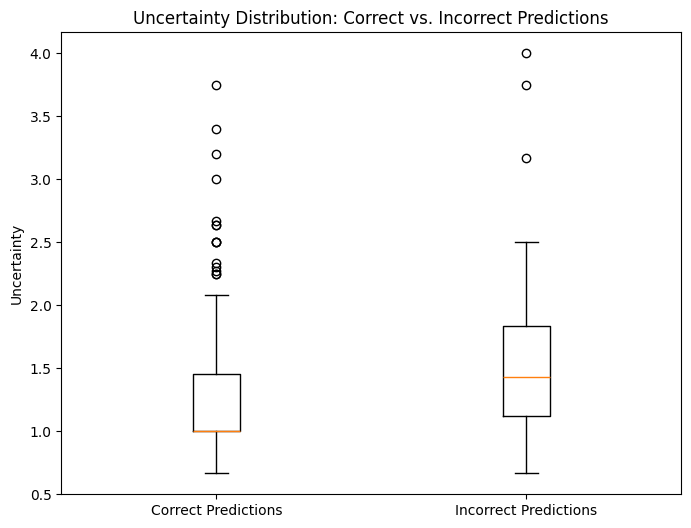

In [388]:
def event_matches(pred_event, gt_event, tolerance):
    """
    Returns True if the predicted event matches the ground truth event
    within the given tolerance for start and end times, and if the From and To values match exactly.
    """
    return (abs(pred_event["Start Time [s]"] - gt_event["Start Time [s]"]) <= tolerance and
            abs(pred_event["End Time [s]"] - gt_event["End Time [s]"]) <= tolerance and
            pred_event["From"] == gt_event["From"] and
            pred_event["To"] == gt_event["To"])

def evaluate_predictions_with_uncertainty(pred_df, gt_df, tolerance):
    """
    For each predicted event in pred_df, determine if it matches any ground truth event in gt_df.
    
    Returns:
      - confusion: a dictionary with TP, FP, and FN counts.
      - correct_uncertainties: list of uncertainty values for predicted events that are true positives.
      - incorrect_uncertainties: list of uncertainty values for predicted events that are false positives.
    
    Here, a predicted event is considered correct (TP) if there is at least one ground truth event
    that matches its Start and End times within the given tolerance and has the same From and To values.
    Ground truth events not matched by any prediction are counted as FN.
    """
    TP = 0
    FP = 0
    matched_gt = set()  # Indices of ground truth events that were matched
    correct_uncertainties = []
    incorrect_uncertainties = []
    
    # For each predicted event, try to find a matching ground truth event.
    for i, pred in pred_df.iterrows():
        match_found = False
        for j, gt in gt_df.iterrows():
            if event_matches(pred, gt, tolerance):
                match_found = True
                matched_gt.add(j)
                break  # Stop at first match for this prediction.
        if match_found:
            TP += 1
            correct_uncertainties.append(pred["uncertainty"])
        else:
            FP += 1
            incorrect_uncertainties.append(pred["uncertainty"])
    
    FN = len(gt_df) - len(matched_gt)
    
    confusion = {"TP": TP, "FP": FP, "FN": FN}
    return confusion, correct_uncertainties, incorrect_uncertainties

# Example data frames (replace these with your actual data)
# Set tolerance (in seconds) for matching event times.
tolerance = 7

# Evaluate predictions and get confusion metrics along with uncertainty values.
confusion, correct_unc, incorrect_unc = evaluate_predictions_with_uncertainty( df_filtered,event_data_passes_subset, tolerance)

print("Confusion Metrics:")
print(confusion)

# Optionally, plot the distribution of uncertainty values for correct vs. incorrect predictions.
plt.figure(figsize=(8,6))
plt.boxplot([correct_unc, incorrect_unc], labels=["Correct Predictions", "Incorrect Predictions"])
plt.ylabel("Uncertainty")
plt.title("Uncertainty Distribution: Correct vs. Incorrect Predictions")
plt.show()


In [389]:
import pandas as pd
import statsmodels.api as sm

# Create a DataFrame where 'error' is 0 for correct and 1 for error:
df_correct = pd.DataFrame({"uncertainty": correct_unc, "error": 0})
df_incorrect = pd.DataFrame({"uncertainty": incorrect_unc, "error": 1})
reg_df = pd.concat([df_correct, df_incorrect], ignore_index=True)

# Add an intercept column:
reg_df["intercept"] = 1.0
logit_model = sm.Logit(reg_df["error"], reg_df[["intercept", "uncertainty"]])
result = logit_model.fit(disp=False)  # disp=False to suppress fitting output

print(result.summary())

# Extract the p-value for uncertainty:
p_value_uncertainty = result.pvalues["uncertainty"]
print(f"\nP-value for uncertainty coefficient: {p_value_uncertainty:.4f}")


                           Logit Regression Results                           
Dep. Variable:                  error   No. Observations:                  700
Model:                          Logit   Df Residuals:                      698
Method:                           MLE   Df Model:                            1
Date:                Fri, 21 Feb 2025   Pseudo R-squ.:                 0.05453
Time:                        12:05:15   Log-Likelihood:                -225.35
converged:                       True   LL-Null:                       -238.35
Covariance Type:            nonrobust   LLR p-value:                 3.424e-07
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -3.8129      0.369    -10.320      0.000      -4.537      -3.089
uncertainty     1.2342      0.240      5.138      0.000       0.763       1.705

P-value for uncertainty coefficient: 0.0000
